# Visualise targets for simulation from IY010_simulation.py

3D plot showing the targets for simulation

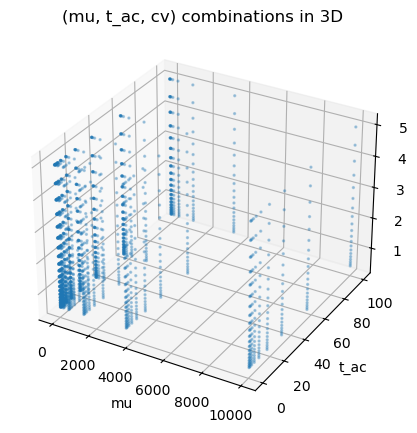

In [9]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
# Load the full grid of verified targets (IY010_simulation.py)
mu_target = np.logspace(0, 4, 10)  # 1 to 10000
t_ac_target = np.logspace(-0.3, 2, 10)  # ~0.5 to 100
cv_target = np.logspace(-0.3, 0.7, 20)  # ~0.5 to 5

targets = np.array(np.meshgrid(mu_target, t_ac_target, cv_target)).T.reshape(-1, 3)

# Create a 3D scatter plot of mu vs t_ac vs cv
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(targets[:, 0], targets[:, 1], targets[:, 2], s=2, alpha=0.3)
ax.set_xlabel('mu')
ax.set_ylabel('t_ac')
ax.set_zlabel('cv')
ax.set_title('(mu, t_ac, cv) combinations in 3D')
plt.show()


Data distribution plots for the specified stats

CV values range from 0.50 to 5.01.


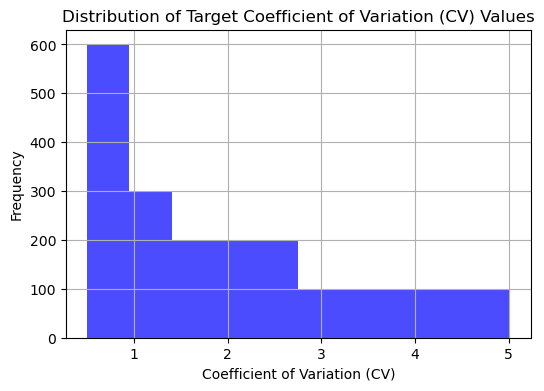

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
df_targets = pd.DataFrame(targets, columns=['mu', 't_ac', 'cv'])
# what ranges of CV values are chosen? 
cv_min = df_targets['cv'].min()
cv_max = df_targets['cv'].max()
print(f"CV values range from {cv_min:.2f} to {cv_max:.2f}.")
# plot the distribution of cv values chosen
plt.figure(figsize=(6, 4))
plt.hist(df_targets['cv'], bins=10, color='blue', alpha=0.7)
plt.xlabel('Coefficient of Variation (CV)')
plt.ylabel('Frequency')
plt.title('Distribution of Target Coefficient of Variation (CV) Values')
plt.grid()  
plt.show()

mu values range from 1.00 to 10000.00.


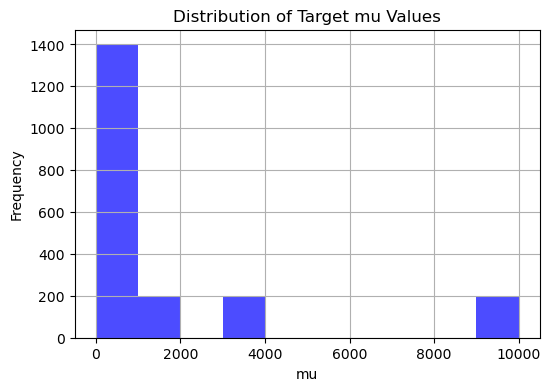

In [11]:
mu_min = df_targets['mu'].min()
mu_max = df_targets['mu'].max()
print(f"mu values range from {mu_min:.2f} to {mu_max:.2f}.")
# plot the distribution 
plt.figure(figsize=(6, 4))
plt.hist(df_targets['mu'], bins=10, color='blue', alpha=0.7)
plt.xlabel('mu')
plt.ylabel('Frequency')
plt.title('Distribution of Target mu Values')
plt.grid()  
plt.show()

t_ac values range from 0.50 to 100.00.


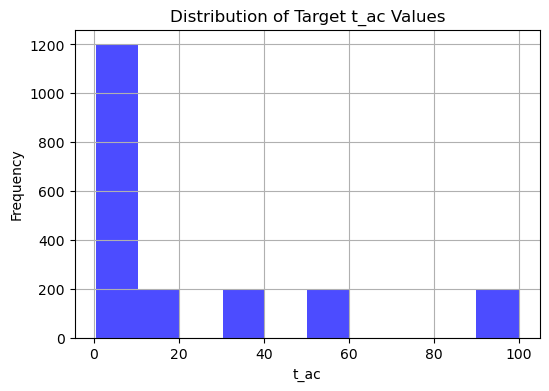

In [12]:
t_ac_min = df_targets['t_ac'].min()
t_ac_max = df_targets['t_ac'].max()
print(f"t_ac values range from {t_ac_min:.2f} to {t_ac_max:.2f}.")
# plot the distribution 
plt.figure(figsize=(6, 4))
plt.hist(df_targets['t_ac'], bins=10, color='blue', alpha=0.7)
plt.xlabel('t_ac')
plt.ylabel('Frequency')
plt.title('Distribution of Target t_ac Values')
plt.grid()  
plt.show()

2D histograms for pairwise parameter combinations

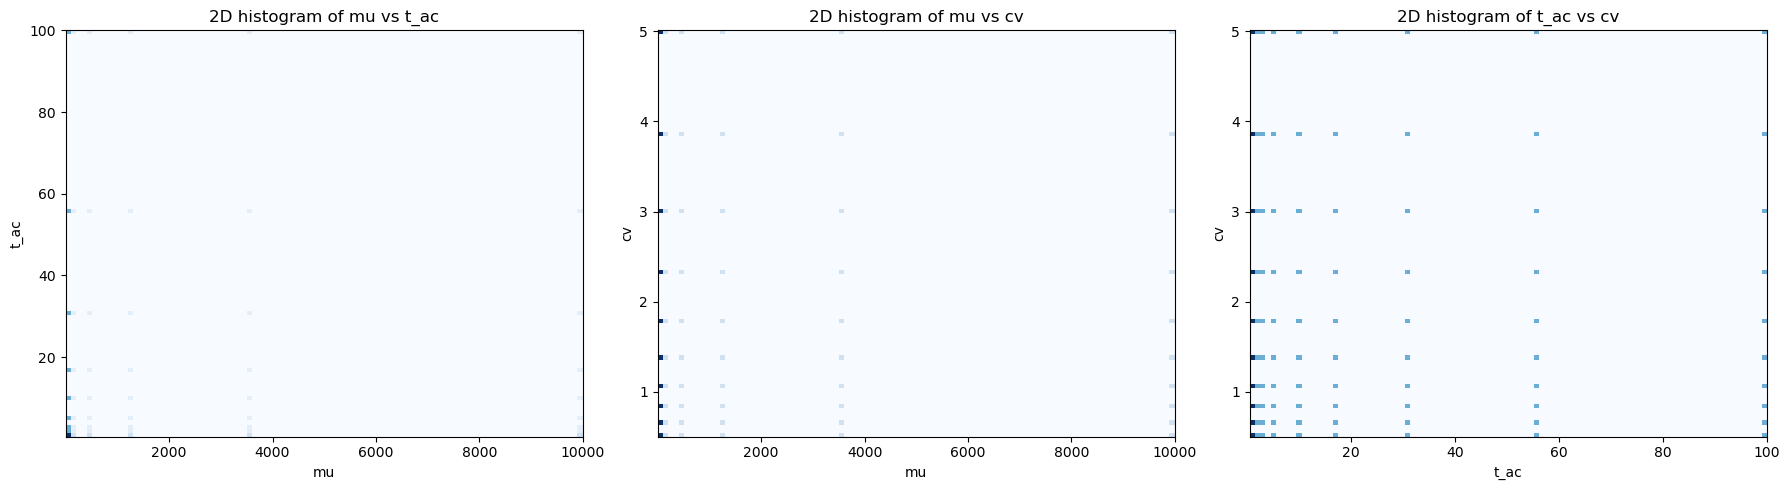

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist2d(df_targets['mu'], df_targets['t_ac'], bins=100, cmap='Blues')
axes[0].set_xlabel('mu')
axes[0].set_ylabel('t_ac')
axes[0].set_title('2D histogram of mu vs t_ac')

axes[1].hist2d(df_targets['mu'], df_targets['cv'], bins=100, cmap='Blues')
axes[1].set_xlabel('mu')
axes[1].set_ylabel('cv')
axes[1].set_title('2D histogram of mu vs cv')

axes[2].hist2d(df_targets['t_ac'], df_targets['cv'], bins=100, cmap='Blues')
axes[2].set_xlabel('t_ac')
axes[2].set_ylabel('cv')
axes[2].set_title('2D histogram of t_ac vs cv')

plt.tight_layout()
plt.show()

## Inspect simulated data stats
Visualise realised vs target statistics

Success rate: 78.85% (1577 out of 2000)


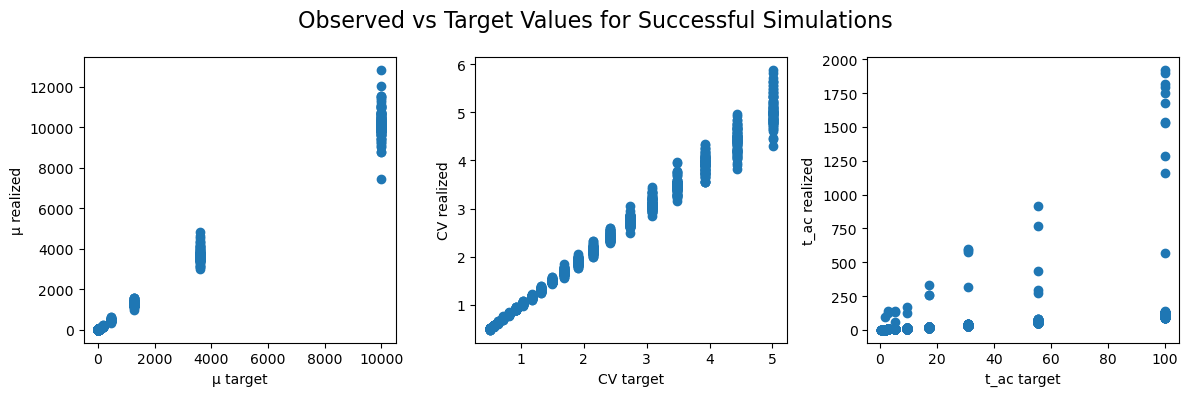

In [13]:
import pandas as pd, numpy as np
from pathlib import Path
from stats.mean import calculate_mean
from stats.variance import calculate_variance
from stats.cv import calculate_cv
from stats.autocorrelation import autocrosscorr, calculate_ac_time_interp1d
import matplotlib.pyplot as plt

data_dir = Path('/home/ianyang/stochastic_simulations/experiments/EXP-25-IY010/data')
# this is the csv file showing the result record with the system parameters, observed stats, rel. errors and trajectory filenames
results = pd.read_csv(f'/home/ianyang/stochastic_simulations/experiments/EXP-25-IY010/data/parameter_testing_results_20250819_094054.csv')
success_results = results[results['success'] == True].reset_index(drop=True)
# print success rate
success_rate = len(success_results) / len(results)
print(f"Success rate: {success_rate:.2%} ({len(success_results)} out of {len(results)})")
# plot comparison
fig, axes = plt.subplots(1,3, figsize=(12,4))
plt.suptitle('Observed vs Target Values for Successful Simulations', fontsize=16)
axes[0].scatter(success_results['mu_target'], success_results['mu_observed'])
axes[0].set_xlabel('μ target'); axes[0].set_ylabel('μ realized')
axes[1].scatter(success_results['cv_target'], success_results['cv_observed'])
axes[1].set_xlabel('CV target'); axes[1].set_ylabel('CV realized')
axes[2].scatter(success_results['t_ac_target'], success_results['t_ac_observed'])
axes[2].set_xlabel('t_ac target'); axes[2].set_ylabel('t_ac realized')
plt.tight_layout()
plt.show()

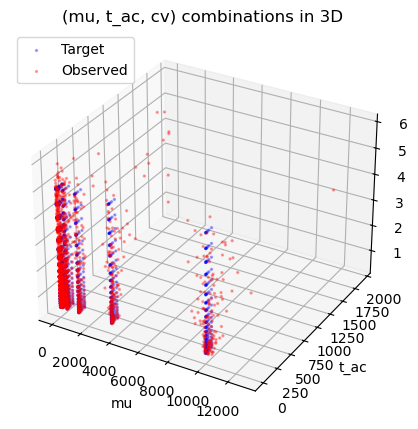

CV target values range from 0.50 to 5.01.
Observed CV values range from 0.48 to 5.89.


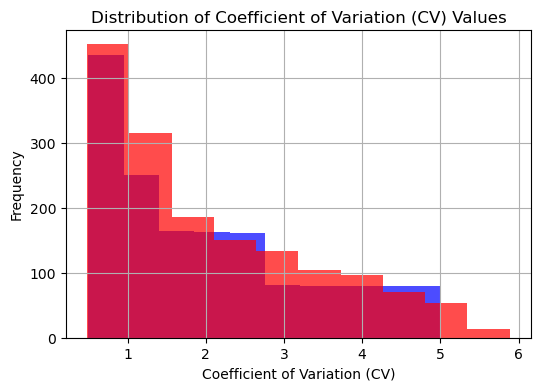

mu target values range from 1.00 to 10000.00.
Observed mu values range from 0.84 to 12852.84.


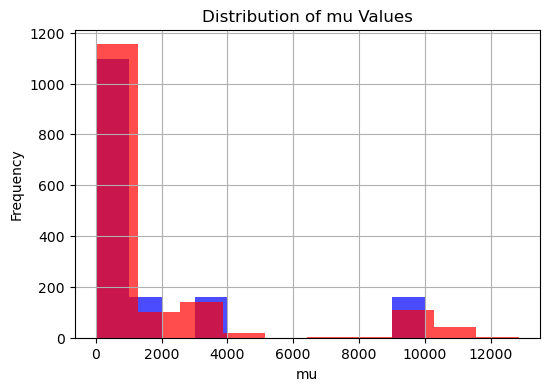

t_ac target values range from 0.50 to 100.00.
Observed t_ac values range from 0.74 to 1923.28.


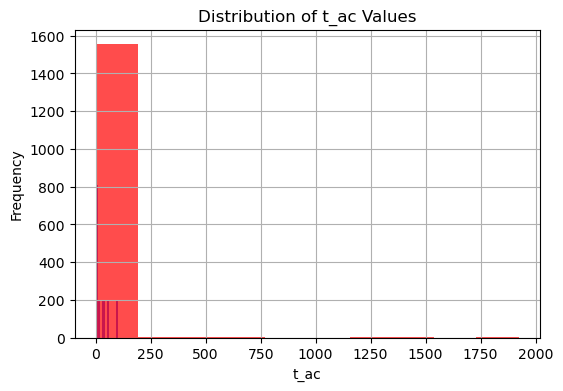

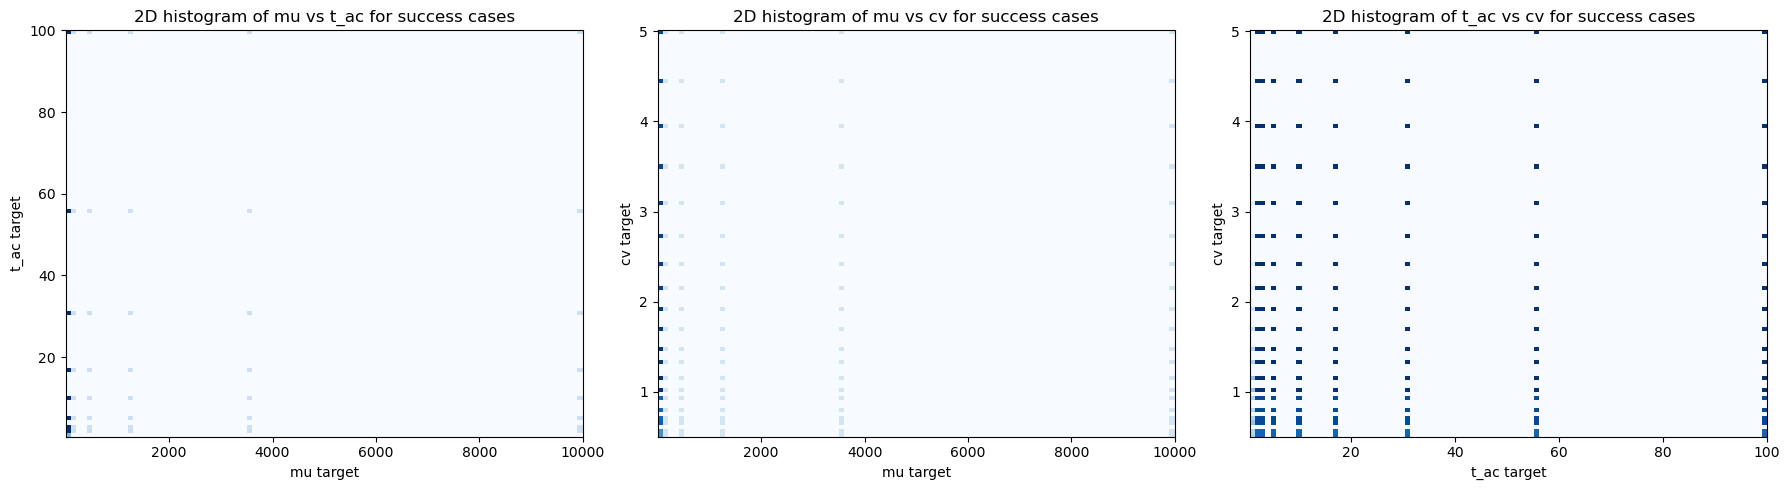

In [14]:
# Create a 3D scatter plot of mu vs t_ac vs cv
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(success_results['mu_target'], success_results['t_ac_target'], success_results['cv_target'], s=2, alpha=0.3, color='blue')
ax.scatter(success_results['mu_observed'], success_results['t_ac_observed'], success_results['cv_observed'], s=2, alpha=0.3, color='red')
ax.legend(['Target', 'Observed'], loc='upper left')
ax.set_xlabel('mu')
ax.set_ylabel('t_ac')
ax.set_zlabel('cv')
ax.set_title('(mu, t_ac, cv) combinations in 3D')
plt.show()
# data distribution plots: CV
cv_target_min = success_results['cv_target'].min()
cv_target_max = success_results['cv_target'].max()
print(f"CV target values range from {cv_target_min:.2f} to {cv_target_max:.2f}.")
cv_observed_min = success_results['cv_observed'].min()
cv_observed_max = success_results['cv_observed'].max()
print(f"Observed CV values range from {cv_observed_min:.2f} to {cv_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['cv_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['cv_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('Coefficient of Variation (CV)')
plt.ylabel('Frequency')
plt.title('Distribution of Coefficient of Variation (CV) Values')
plt.grid()  
plt.show()
# data distribution plots: Mu
mu_target_min = success_results['mu_target'].min()
mu_target_max = success_results['mu_target'].max()
print(f"mu target values range from {mu_target_min:.2f} to {mu_target_max:.2f}.")
mu_observed_min = success_results['mu_observed'].min()
mu_observed_max = success_results['mu_observed'].max()
print(f"Observed mu values range from {mu_observed_min:.2f} to {mu_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['mu_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['mu_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('mu')
plt.ylabel('Frequency')
plt.title('Distribution of mu Values')
plt.grid()  
plt.show()
# data distribution plots: t_ac
t_ac_target_min = success_results['t_ac_target'].min()
t_ac_target_max = success_results['t_ac_target'].max()
print(f"t_ac target values range from {t_ac_target_min:.2f} to {t_ac_target_max:.2f}.")
t_ac_observed_min = success_results['t_ac_observed'].min()
t_ac_observed_max = success_results['t_ac_observed'].max()
print(f"Observed t_ac values range from {t_ac_observed_min:.2f} to {t_ac_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['t_ac_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['t_ac_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('t_ac')
plt.ylabel('Frequency')
plt.title('Distribution of t_ac Values')
plt.grid()  
plt.show()
# pairwise plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist2d(success_results['mu_target'], success_results['t_ac_target'], bins=100, cmap='Blues')
axes[0].set_xlabel('mu target')
axes[0].set_ylabel('t_ac target')
axes[0].set_title('2D histogram of mu vs t_ac for success cases')
axes[1].hist2d(success_results['mu_target'], success_results['cv_target'], bins=100, cmap='Blues')
axes[1].set_xlabel('mu target')
axes[1].set_ylabel('cv target')
axes[1].set_title('2D histogram of mu vs cv for success cases')
axes[2].hist2d(success_results['t_ac_target'], success_results['cv_target'], bins=100, cmap='Blues')
axes[2].set_xlabel('t_ac target')
axes[2].set_ylabel('cv target')
axes[2].set_title('2D histogram of t_ac vs cv for success cases')
plt.tight_layout()
plt.show()  


## What's the rel. error distribution? 

mu rel. error values range from 0.00 to 44.83.
Median mu relative error: 2.20%
3rd quartile mu relative error: 5.05%


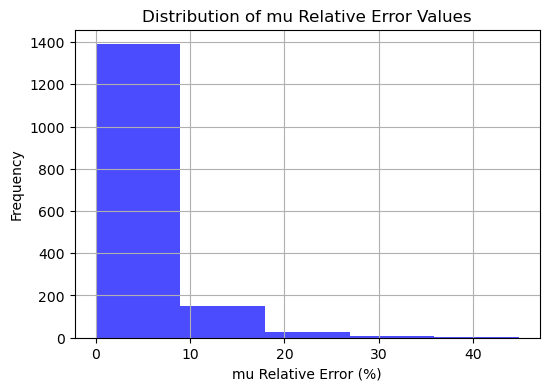

cv rel. error values range from 0.00 to 17.44.
Median cv relative error: 1.46%
3rd quartile cv relative error: 2.89%


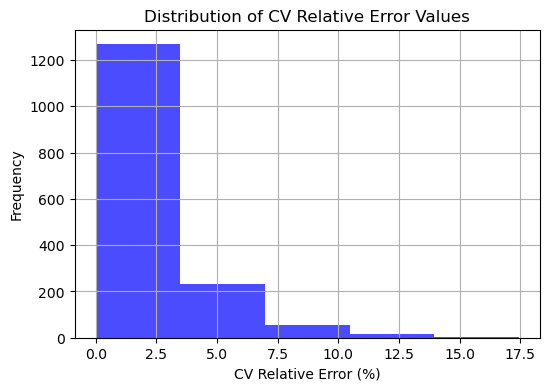

t_ac rel. error values range from 0.00 to 5658.36.
Median t_ac relative error: 5.28%
3rd quartile t_ac relative error: 10.45%


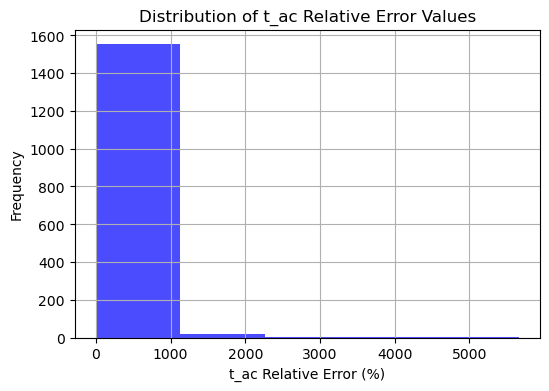

In [15]:
# plot relative error distribution
mu_err_min = success_results['mean_rel_error_pct'].min()
mu_err_max = success_results['mean_rel_error_pct'].max()
print(f"mu rel. error values range from {mu_err_min:.2f} to {mu_err_max:.2f}.")
# median relative error
median_mu_err = success_results['mean_rel_error_pct'].median()
print(f"Median mu relative error: {median_mu_err:.2f}%")
# 3rd quantile
q3_mu_err = success_results['mean_rel_error_pct'].quantile(0.75)
print(f"3rd quartile mu relative error: {q3_mu_err:.2f}%")
# plot the distribution 
plt.figure(figsize=(6, 4))
plt.hist(success_results['mean_rel_error_pct'], bins=5, color='blue', alpha=0.7)
plt.xlabel('mu Relative Error (%)')
plt.ylabel('Frequency')
plt.title('Distribution of mu Relative Error Values')
plt.grid()  
plt.show()
# --
# plot dist for the other errors
cv_err_min = success_results['cv_rel_error_pct'].min()
cv_err_max = success_results['cv_rel_error_pct'].max()
print(f"cv rel. error values range from {cv_err_min:.2f} to {cv_err_max:.2f}.")
# median relative error
median_cv_err = success_results['cv_rel_error_pct'].median()
print(f"Median cv relative error: {median_cv_err:.2f}%")
# 3rd quantile
q3_cv_err = success_results['cv_rel_error_pct'].quantile(0.75)
print(f"3rd quartile cv relative error: {q3_cv_err:.2f}%")
# plot the distribution 
plt.figure(figsize=(6, 4))
plt.hist(success_results['cv_rel_error_pct'], bins=5, color='blue', alpha=0.7)
plt.xlabel('CV Relative Error (%)')
plt.ylabel('Frequency')
plt.title('Distribution of CV Relative Error Values')
plt.grid()  
plt.show()
# -- 
t_ac_err_min = success_results['ac_rel_error_pct'].min()    
t_ac_err_max = success_results['ac_rel_error_pct'].max()
print(f"t_ac rel. error values range from {t_ac_err_min:.2f} to {t_ac_err_max:.2f}.")
# median relative error
median_t_ac_err = success_results['ac_rel_error_pct'].median()
print(f"Median t_ac relative error: {median_t_ac_err:.2f}%")
# 3rd quantile
q3_t_ac_err = success_results['ac_rel_error_pct'].quantile(0.75)
print(f"3rd quartile t_ac relative error: {q3_t_ac_err:.2f}%")
# plot the distribution
plt.figure(figsize=(6, 4))
plt.hist(success_results['ac_rel_error_pct'], bins=5, color='blue', alpha=0.7)
plt.xlabel('t_ac Relative Error (%)')
plt.ylabel('Frequency')
plt.title('Distribution of t_ac Relative Error Values')
plt.grid()  
plt.show()

Use the above insights to narrow down to cases where relative errors are small

Success rate (less than 20% relative error): 68.05% (1361 out of 2000)


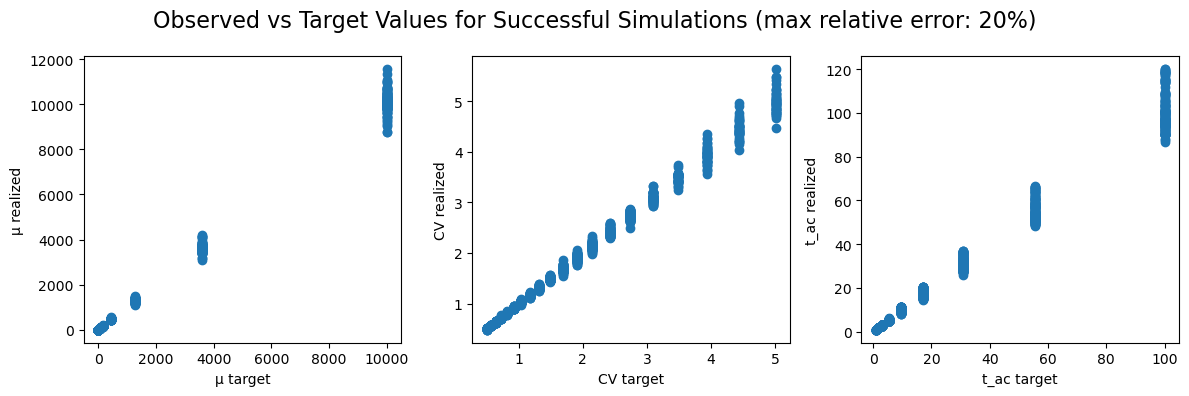

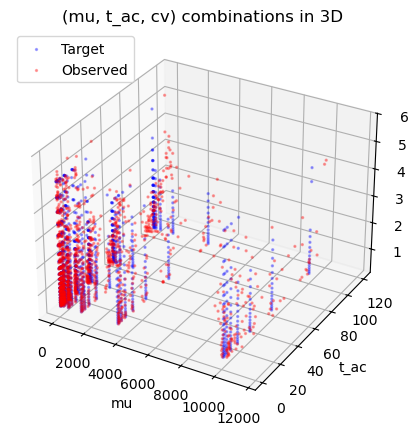

CV target values range from 0.50 to 5.01.
Observed CV values range from 0.48 to 5.63.


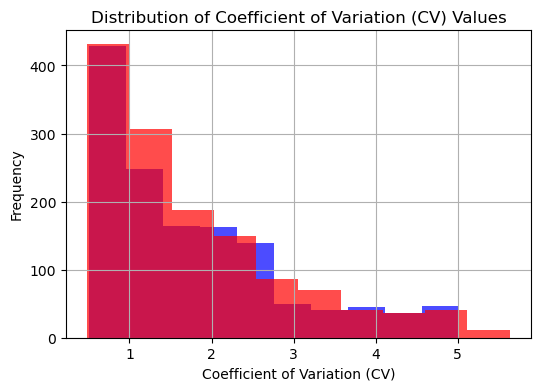

mu target values range from 1.00 to 10000.00.
Observed mu values range from 0.84 to 11560.70.


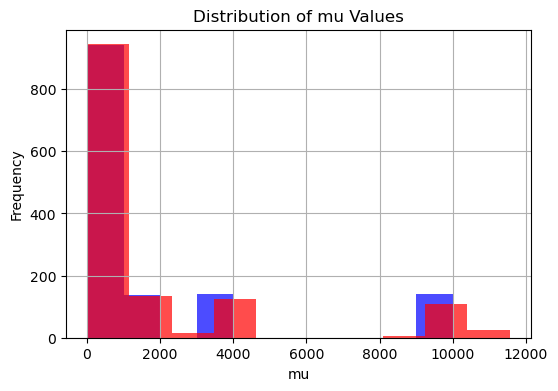

t_ac target values range from 0.90 to 100.00.
Observed t_ac values range from 0.92 to 119.99.


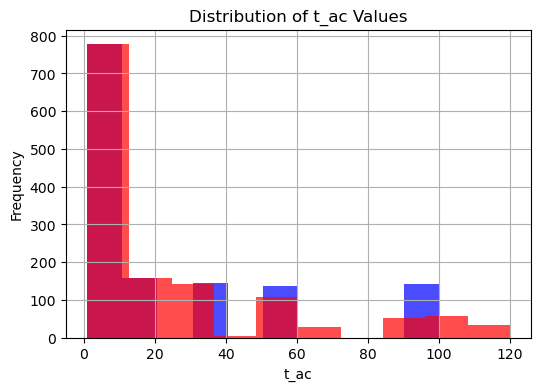

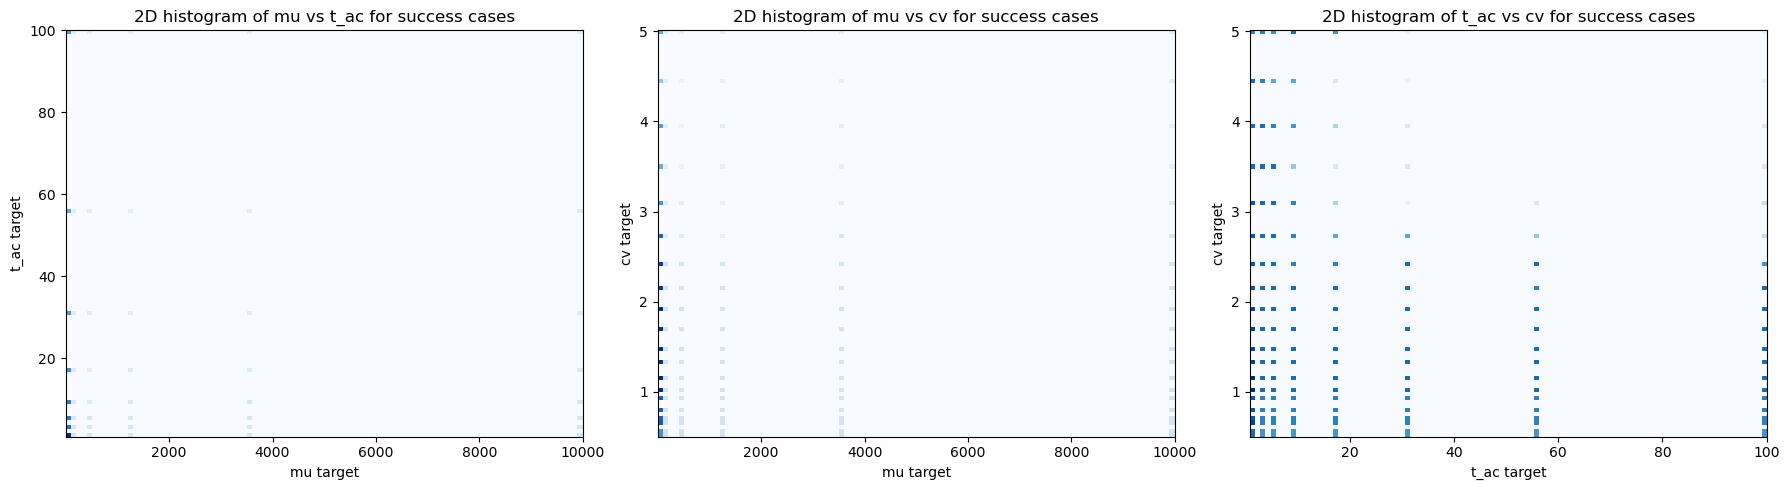

In [17]:
max_rel_err = 20
success_results_20pct_err = success_results[
    (success_results['mean_rel_error_pct'] < max_rel_err) &
    (success_results['cv_rel_error_pct'] < max_rel_err) &
    (success_results['ac_rel_error_pct'] < max_rel_err)
].reset_index(drop=True)
success_rate_20pct_err = len(success_results_20pct_err) / len(results)
print(f'Success rate (less than {max_rel_err}% relative error): {success_rate_20pct_err:.2%} ({len(success_results_20pct_err)} out of {len(results)})')

fig, axes = plt.subplots(1,3, figsize=(12,4))
plt.suptitle(f'Observed vs Target Values for Successful Simulations (max relative error: {max_rel_err}%)', fontsize=16)
axes[0].scatter(success_results_20pct_err['mu_target'], success_results_20pct_err['mu_observed'])
axes[0].set_xlabel('μ target'); axes[0].set_ylabel('μ realized')
axes[1].scatter(success_results_20pct_err['cv_target'], success_results_20pct_err['cv_observed'])
axes[1].set_xlabel('CV target'); axes[1].set_ylabel('CV realized')
axes[2].scatter(success_results_20pct_err['t_ac_target'], success_results_20pct_err['t_ac_observed'])
axes[2].set_xlabel('t_ac target'); axes[2].set_ylabel('t_ac realized')
plt.tight_layout()
plt.show()
# -- 
success_results = success_results_20pct_err
# Create a 3D scatter plot of mu vs t_ac vs cv
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(success_results['mu_target'], success_results['t_ac_target'], success_results['cv_target'], s=2, alpha=0.3, color='blue')
ax.scatter(success_results['mu_observed'], success_results['t_ac_observed'], success_results['cv_observed'], s=2, alpha=0.3, color='red')
ax.legend(['Target', 'Observed'], loc='upper left')
ax.set_xlabel('mu')
ax.set_ylabel('t_ac')
ax.set_zlabel('cv')
ax.set_title('(mu, t_ac, cv) combinations in 3D')
plt.show()
# data distribution plots: CV
cv_target_min = success_results['cv_target'].min()
cv_target_max = success_results['cv_target'].max()
print(f"CV target values range from {cv_target_min:.2f} to {cv_target_max:.2f}.")
cv_observed_min = success_results['cv_observed'].min()
cv_observed_max = success_results['cv_observed'].max()
print(f"Observed CV values range from {cv_observed_min:.2f} to {cv_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['cv_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['cv_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('Coefficient of Variation (CV)')
plt.ylabel('Frequency')
plt.title('Distribution of Coefficient of Variation (CV) Values')
plt.grid()  
plt.show()
# data distribution plots: Mu
mu_target_min = success_results['mu_target'].min()
mu_target_max = success_results['mu_target'].max()
print(f"mu target values range from {mu_target_min:.2f} to {mu_target_max:.2f}.")
mu_observed_min = success_results['mu_observed'].min()
mu_observed_max = success_results['mu_observed'].max()
print(f"Observed mu values range from {mu_observed_min:.2f} to {mu_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['mu_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['mu_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('mu')
plt.ylabel('Frequency')
plt.title('Distribution of mu Values')
plt.grid()  
plt.show()
# data distribution plots: t_ac
t_ac_target_min = success_results['t_ac_target'].min()
t_ac_target_max = success_results['t_ac_target'].max()
print(f"t_ac target values range from {t_ac_target_min:.2f} to {t_ac_target_max:.2f}.")
t_ac_observed_min = success_results['t_ac_observed'].min()
t_ac_observed_max = success_results['t_ac_observed'].max()
print(f"Observed t_ac values range from {t_ac_observed_min:.2f} to {t_ac_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['t_ac_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['t_ac_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('t_ac')
plt.ylabel('Frequency')
plt.title('Distribution of t_ac Values')
plt.grid()  
plt.show()
# pairwise plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist2d(success_results['mu_target'], success_results['t_ac_target'], bins=100, cmap='Blues')
axes[0].set_xlabel('mu target')
axes[0].set_ylabel('t_ac target')
axes[0].set_title('2D histogram of mu vs t_ac for success cases')
axes[1].hist2d(success_results['mu_target'], success_results['cv_target'], bins=100, cmap='Blues')
axes[1].set_xlabel('mu target')
axes[1].set_ylabel('cv target')
axes[1].set_title('2D histogram of mu vs cv for success cases')
axes[2].hist2d(success_results['t_ac_target'], success_results['cv_target'], bins=100, cmap='Blues')
axes[2].set_xlabel('t_ac target')
axes[2].set_ylabel('cv target')
axes[2].set_title('2D histogram of t_ac vs cv for success cases')
plt.tight_layout()
plt.show()  

Success rate (less than 10% relative error): 56.55% (1131 out of 2000)


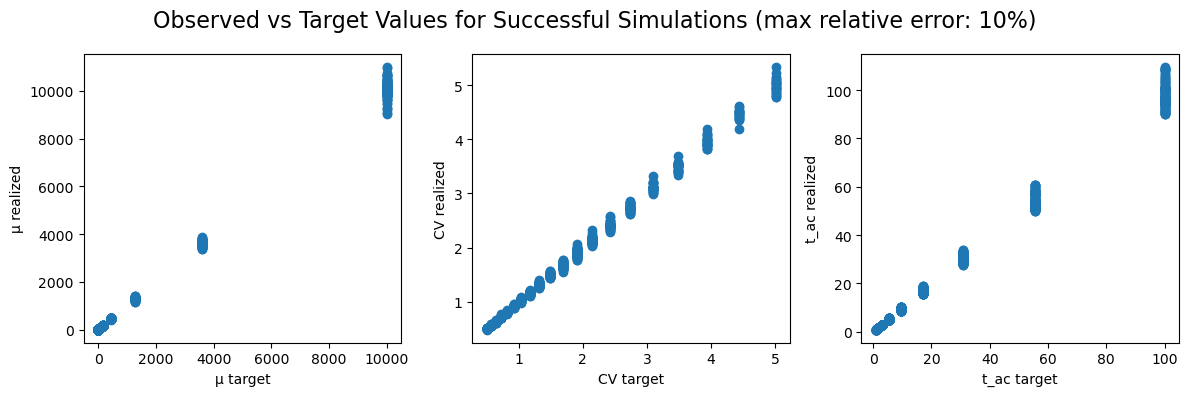

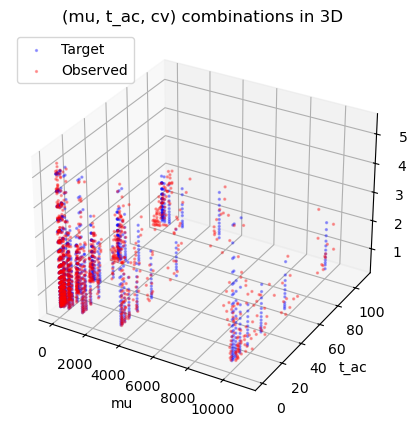

CV target values range from 0.50 to 5.01.
Observed CV values range from 0.49 to 5.33.


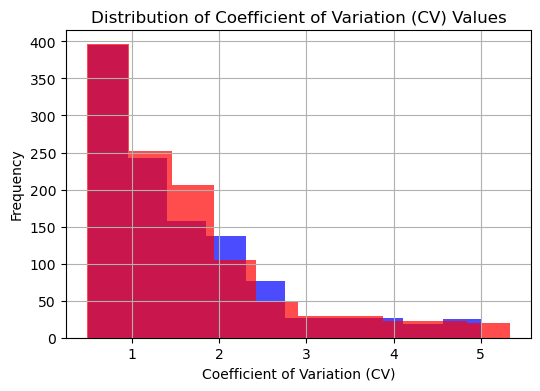

mu target values range from 1.00 to 10000.00.
Observed mu values range from 0.90 to 10997.92.


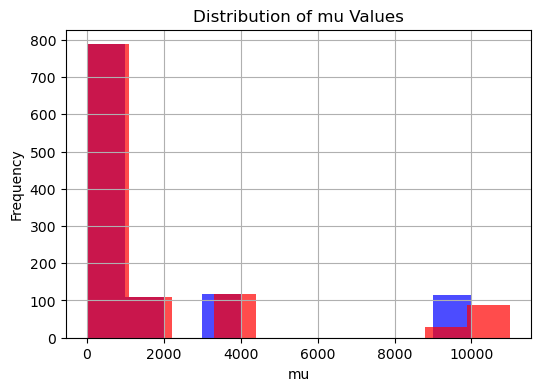

t_ac target values range from 0.90 to 100.00.
Observed t_ac values range from 0.92 to 109.46.


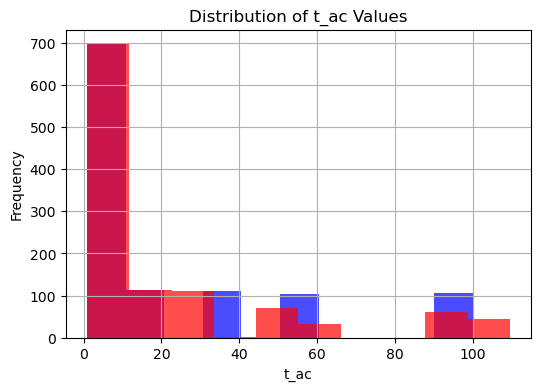

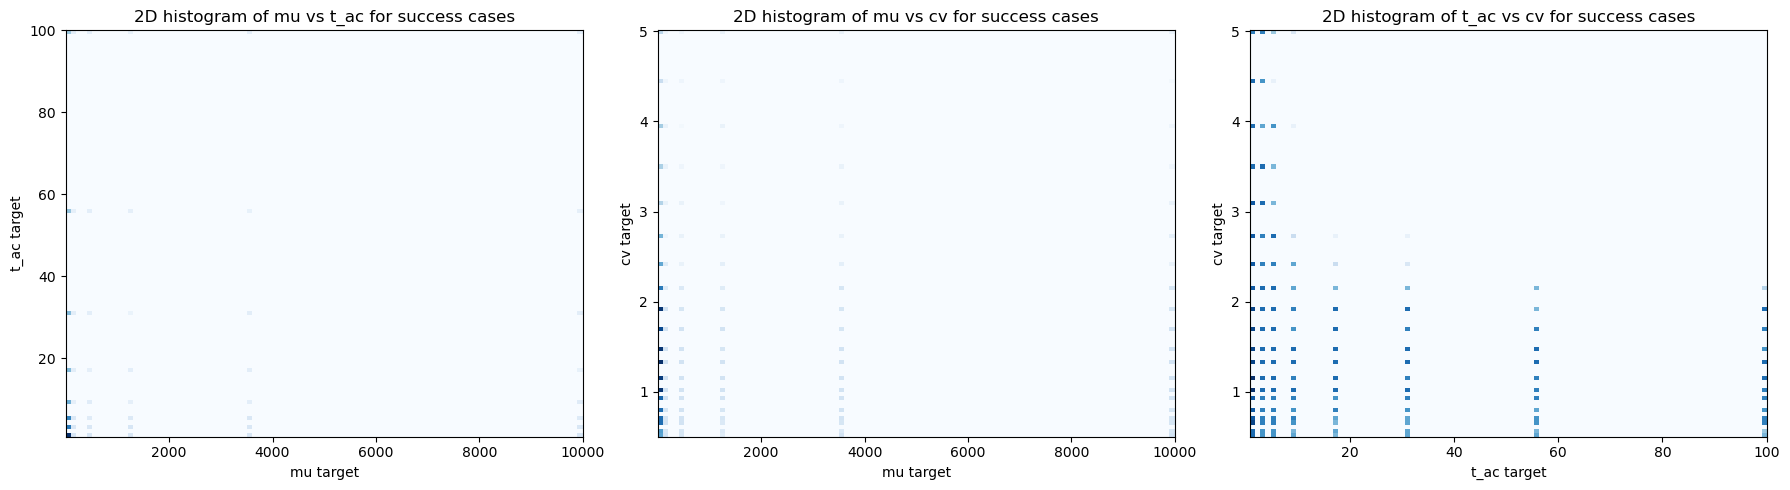

In [18]:
max_rel_err = 10
success_results_10pct_err = success_results[
    (success_results['mean_rel_error_pct'] < max_rel_err) &
    (success_results['cv_rel_error_pct'] < max_rel_err) &
    (success_results['ac_rel_error_pct'] < max_rel_err)
].reset_index(drop=True)
success_rate_10pct_err = len(success_results_10pct_err) / len(results)
print(f'Success rate (less than {max_rel_err}% relative error): {success_rate_10pct_err:.2%} ({len(success_results_10pct_err)} out of {len(results)})')

fig, axes = plt.subplots(1,3, figsize=(12,4))
plt.suptitle(f'Observed vs Target Values for Successful Simulations (max relative error: {max_rel_err}%)', fontsize=16)
axes[0].scatter(success_results_10pct_err['mu_target'], success_results_10pct_err['mu_observed'])
axes[0].set_xlabel('μ target'); axes[0].set_ylabel('μ realized')
axes[1].scatter(success_results_10pct_err['cv_target'], success_results_10pct_err['cv_observed'])
axes[1].set_xlabel('CV target'); axes[1].set_ylabel('CV realized')
axes[2].scatter(success_results_10pct_err['t_ac_target'], success_results_10pct_err['t_ac_observed'])
axes[2].set_xlabel('t_ac target'); axes[2].set_ylabel('t_ac realized')
plt.tight_layout()
plt.show()
# -- 
success_results = success_results_10pct_err
# Create a 3D scatter plot of mu vs t_ac vs cv
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(success_results['mu_target'], success_results['t_ac_target'], success_results['cv_target'], s=2, alpha=0.3, color='blue')
ax.scatter(success_results['mu_observed'], success_results['t_ac_observed'], success_results['cv_observed'], s=2, alpha=0.3, color='red')
ax.legend(['Target', 'Observed'], loc='upper left')
ax.set_xlabel('mu')
ax.set_ylabel('t_ac')
ax.set_zlabel('cv')
ax.set_title('(mu, t_ac, cv) combinations in 3D')
plt.show()
# data distribution plots: CV
cv_target_min = success_results['cv_target'].min()
cv_target_max = success_results['cv_target'].max()
print(f"CV target values range from {cv_target_min:.2f} to {cv_target_max:.2f}.")
cv_observed_min = success_results['cv_observed'].min()
cv_observed_max = success_results['cv_observed'].max()
print(f"Observed CV values range from {cv_observed_min:.2f} to {cv_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['cv_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['cv_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('Coefficient of Variation (CV)')
plt.ylabel('Frequency')
plt.title('Distribution of Coefficient of Variation (CV) Values')
plt.grid()  
plt.show()
# data distribution plots: Mu
mu_target_min = success_results['mu_target'].min()
mu_target_max = success_results['mu_target'].max()
print(f"mu target values range from {mu_target_min:.2f} to {mu_target_max:.2f}.")
mu_observed_min = success_results['mu_observed'].min()
mu_observed_max = success_results['mu_observed'].max()
print(f"Observed mu values range from {mu_observed_min:.2f} to {mu_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['mu_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['mu_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('mu')
plt.ylabel('Frequency')
plt.title('Distribution of mu Values')
plt.grid()  
plt.show()
# data distribution plots: t_ac
t_ac_target_min = success_results['t_ac_target'].min()
t_ac_target_max = success_results['t_ac_target'].max()
print(f"t_ac target values range from {t_ac_target_min:.2f} to {t_ac_target_max:.2f}.")
t_ac_observed_min = success_results['t_ac_observed'].min()
t_ac_observed_max = success_results['t_ac_observed'].max()
print(f"Observed t_ac values range from {t_ac_observed_min:.2f} to {t_ac_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['t_ac_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['t_ac_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('t_ac')
plt.ylabel('Frequency')
plt.title('Distribution of t_ac Values')
plt.grid()  
plt.show()
# pairwise plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist2d(success_results['mu_target'], success_results['t_ac_target'], bins=100, cmap='Blues')
axes[0].set_xlabel('mu target')
axes[0].set_ylabel('t_ac target')
axes[0].set_title('2D histogram of mu vs t_ac for success cases')
axes[1].hist2d(success_results['mu_target'], success_results['cv_target'], bins=100, cmap='Blues')
axes[1].set_xlabel('mu target')
axes[1].set_ylabel('cv target')
axes[1].set_title('2D histogram of mu vs cv for success cases')
axes[2].hist2d(success_results['t_ac_target'], success_results['cv_target'], bins=100, cmap='Blues')
axes[2].set_xlabel('t_ac target')
axes[2].set_ylabel('cv target')
axes[2].set_title('2D histogram of t_ac vs cv for success cases')
plt.tight_layout()
plt.show()  

Success rate (less than 5% relative error): 31.75% (635 out of 2000)


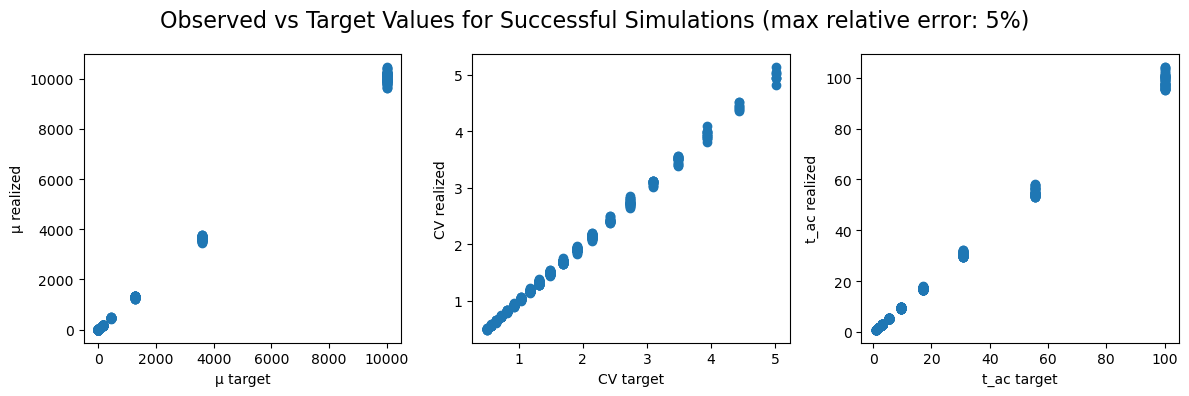

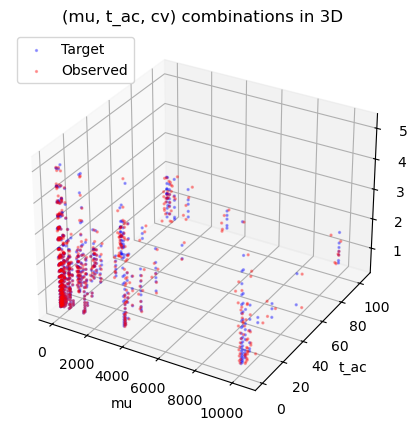

CV target values range from 0.50 to 5.01.
Observed CV values range from 0.49 to 5.13.


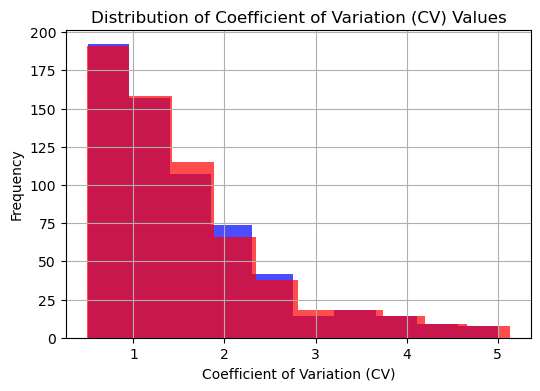

mu target values range from 1.00 to 10000.00.
Observed mu values range from 0.96 to 10459.57.


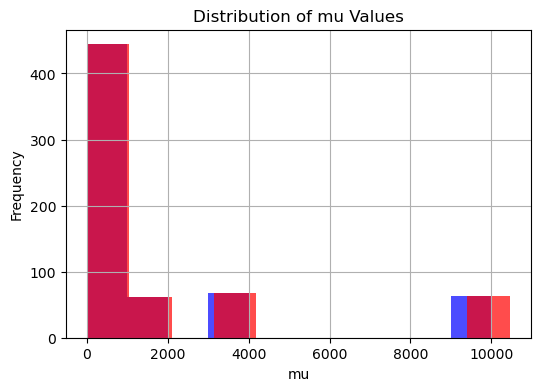

t_ac target values range from 0.90 to 100.00.
Observed t_ac values range from 0.92 to 104.14.


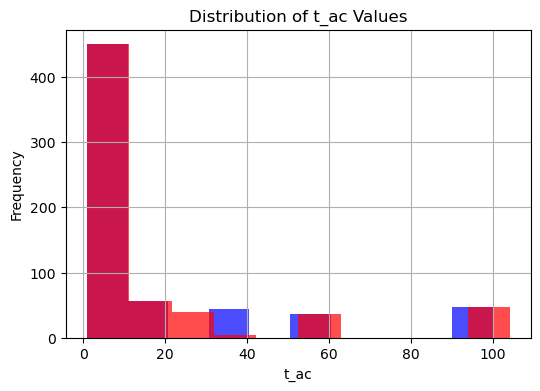

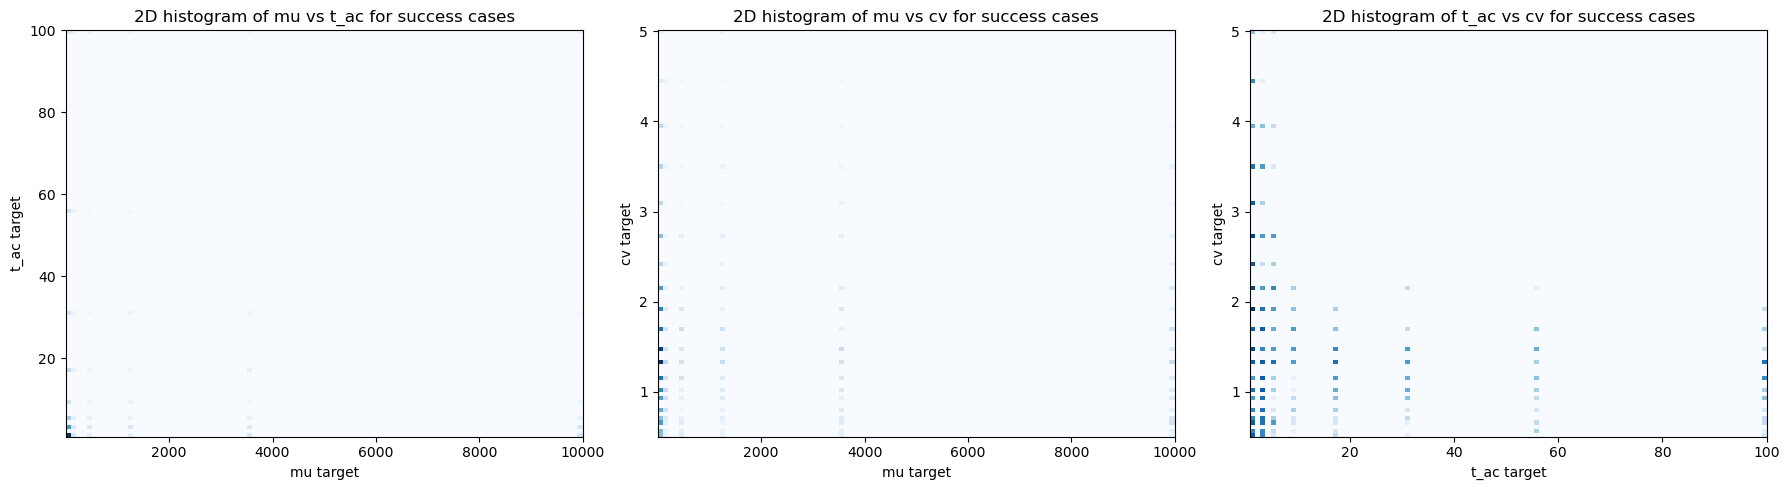

In [19]:
# get cases where relative errors are less than 5%, from success_stats
max_rel_err = 5
success_results_5pct_err = success_results[
    (success_results['mean_rel_error_pct'] < max_rel_err) &
    (success_results['cv_rel_error_pct'] < max_rel_err) &
    (success_results['ac_rel_error_pct'] < max_rel_err)
].reset_index(drop=True)
success_rate_5pct_err = len(success_results_5pct_err) / len(results)
print(f'Success rate (less than {max_rel_err}% relative error): {success_rate_5pct_err:.2%} ({len(success_results_5pct_err)} out of {len(results)})')

fig, axes = plt.subplots(1,3, figsize=(12,4))
plt.suptitle(f'Observed vs Target Values for Successful Simulations (max relative error: {max_rel_err}%)', fontsize=16)
axes[0].scatter(success_results_5pct_err['mu_target'], success_results_5pct_err['mu_observed'])
axes[0].set_xlabel('μ target'); axes[0].set_ylabel('μ realized')
axes[1].scatter(success_results_5pct_err['cv_target'], success_results_5pct_err['cv_observed'])
axes[1].set_xlabel('CV target'); axes[1].set_ylabel('CV realized')
axes[2].scatter(success_results_5pct_err['t_ac_target'], success_results_5pct_err['t_ac_observed'])
axes[2].set_xlabel('t_ac target'); axes[2].set_ylabel('t_ac realized')
plt.tight_layout()
plt.show()

# -- 
success_results = success_results_5pct_err
# Create a 3D scatter plot of mu vs t_ac vs cv
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(success_results['mu_target'], success_results['t_ac_target'], success_results['cv_target'], s=2, alpha=0.3, color='blue')
ax.scatter(success_results['mu_observed'], success_results['t_ac_observed'], success_results['cv_observed'], s=2, alpha=0.3, color='red')
ax.legend(['Target', 'Observed'], loc='upper left')
ax.set_xlabel('mu')
ax.set_ylabel('t_ac')
ax.set_zlabel('cv')
ax.set_title('(mu, t_ac, cv) combinations in 3D')
plt.show()
# data distribution plots: CV
cv_target_min = success_results['cv_target'].min()
cv_target_max = success_results['cv_target'].max()
print(f"CV target values range from {cv_target_min:.2f} to {cv_target_max:.2f}.")
cv_observed_min = success_results['cv_observed'].min()
cv_observed_max = success_results['cv_observed'].max()
print(f"Observed CV values range from {cv_observed_min:.2f} to {cv_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['cv_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['cv_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('Coefficient of Variation (CV)')
plt.ylabel('Frequency')
plt.title('Distribution of Coefficient of Variation (CV) Values')
plt.grid()  
plt.show()
# data distribution plots: Mu
mu_target_min = success_results['mu_target'].min()
mu_target_max = success_results['mu_target'].max()
print(f"mu target values range from {mu_target_min:.2f} to {mu_target_max:.2f}.")
mu_observed_min = success_results['mu_observed'].min()
mu_observed_max = success_results['mu_observed'].max()
print(f"Observed mu values range from {mu_observed_min:.2f} to {mu_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['mu_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['mu_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('mu')
plt.ylabel('Frequency')
plt.title('Distribution of mu Values')
plt.grid()  
plt.show()
# data distribution plots: t_ac
t_ac_target_min = success_results['t_ac_target'].min()
t_ac_target_max = success_results['t_ac_target'].max()
print(f"t_ac target values range from {t_ac_target_min:.2f} to {t_ac_target_max:.2f}.")
t_ac_observed_min = success_results['t_ac_observed'].min()
t_ac_observed_max = success_results['t_ac_observed'].max()
print(f"Observed t_ac values range from {t_ac_observed_min:.2f} to {t_ac_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['t_ac_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['t_ac_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('t_ac')
plt.ylabel('Frequency')
plt.title('Distribution of t_ac Values')
plt.grid()  
plt.show()
# pairwise plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist2d(success_results['mu_target'], success_results['t_ac_target'], bins=100, cmap='Blues')
axes[0].set_xlabel('mu target')
axes[0].set_ylabel('t_ac target')
axes[0].set_title('2D histogram of mu vs t_ac for success cases')
axes[1].hist2d(success_results['mu_target'], success_results['cv_target'], bins=100, cmap='Blues')
axes[1].set_xlabel('mu target')
axes[1].set_ylabel('cv target')
axes[1].set_title('2D histogram of mu vs cv for success cases')
axes[2].hist2d(success_results['t_ac_target'], success_results['cv_target'], bins=100, cmap='Blues')
axes[2].set_xlabel('t_ac target')
axes[2].set_ylabel('cv target')
axes[2].set_title('2D histogram of t_ac vs cv for success cases')
plt.tight_layout()
plt.show()  

Success rate (less than 2% relative error): 6.15% (123 out of 2000)


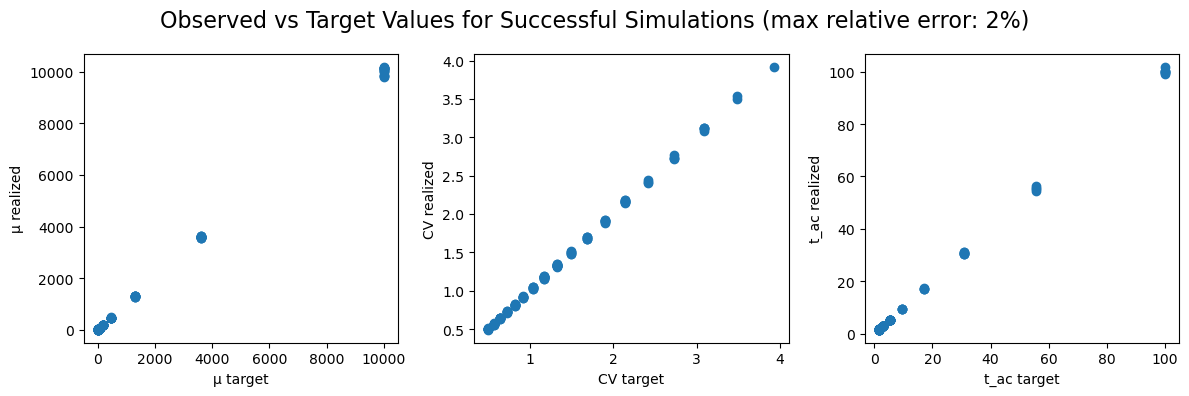

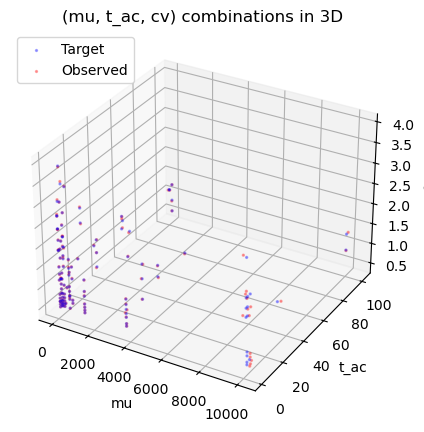

CV target values range from 0.50 to 3.93.
Observed CV values range from 0.49 to 3.91.


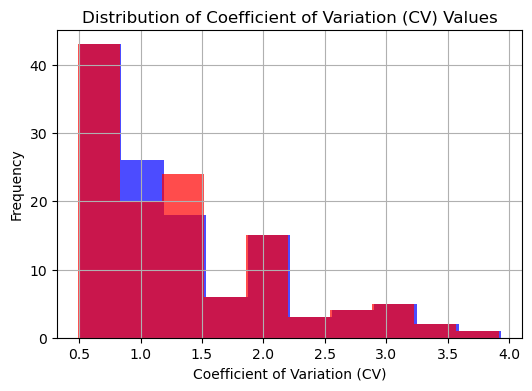

mu target values range from 1.00 to 10000.00.
Observed mu values range from 0.98 to 10184.63.


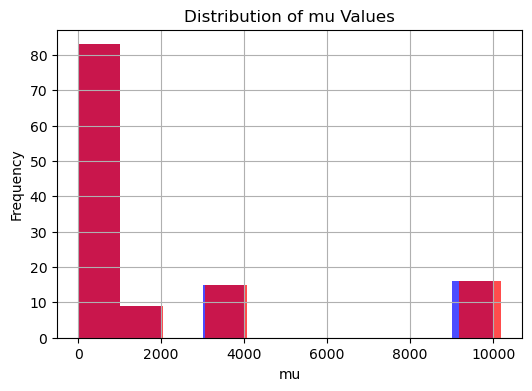

t_ac target values range from 1.63 to 100.00.
Observed t_ac values range from 1.60 to 101.69.


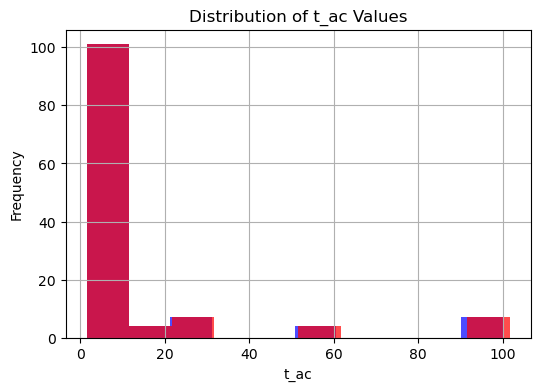

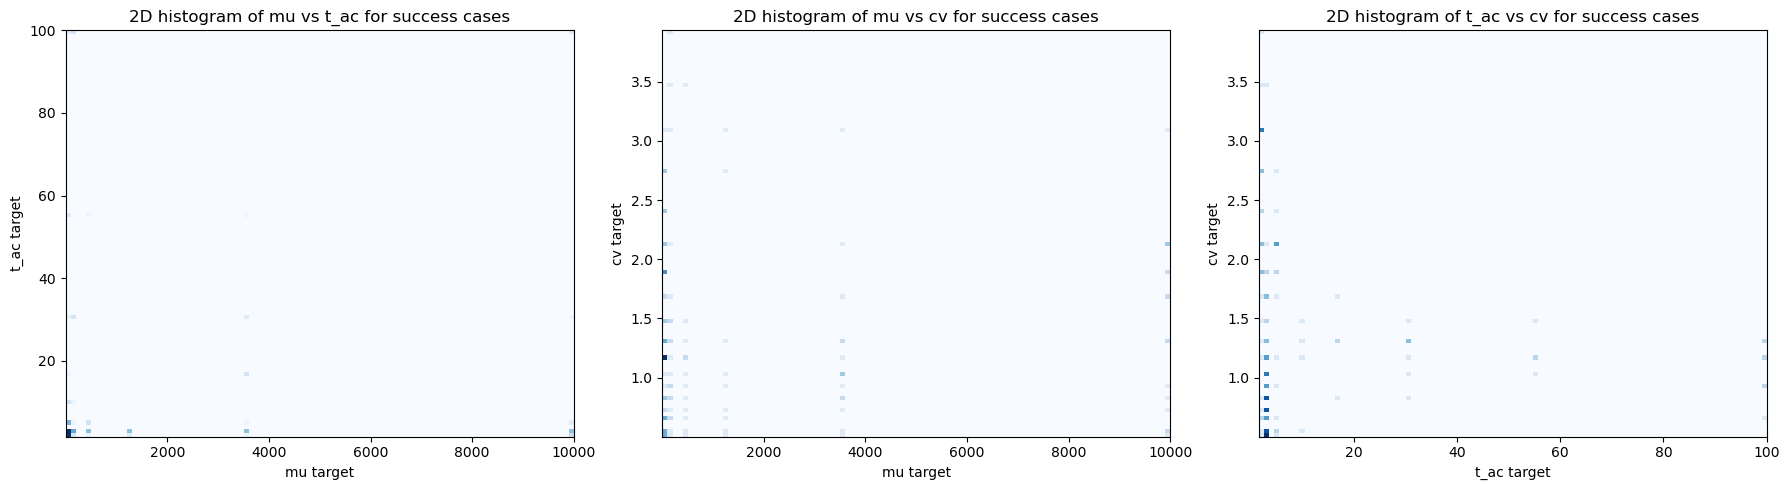

In [20]:
# get cases where relative errors are less than 5%, from success_stats
max_rel_err = 2
success_results_2pct_err = success_results[
    (success_results['mean_rel_error_pct'] < max_rel_err) &
    (success_results['cv_rel_error_pct'] < max_rel_err) &
    (success_results['ac_rel_error_pct'] < max_rel_err)
].reset_index(drop=True)
success_rate_2pct_err = len(success_results_2pct_err) / len(results)
print(f'Success rate (less than {max_rel_err}% relative error): {success_rate_2pct_err:.2%} ({len(success_results_2pct_err)} out of {len(results)})')

fig, axes = plt.subplots(1,3, figsize=(12,4))
plt.suptitle(f'Observed vs Target Values for Successful Simulations (max relative error: {max_rel_err}%)', fontsize=16)
axes[0].scatter(success_results_2pct_err['mu_target'], success_results_2pct_err['mu_observed'])
axes[0].set_xlabel('μ target'); axes[0].set_ylabel('μ realized')
axes[1].scatter(success_results_2pct_err['cv_target'], success_results_2pct_err['cv_observed'])
axes[1].set_xlabel('CV target'); axes[1].set_ylabel('CV realized')
axes[2].scatter(success_results_2pct_err['t_ac_target'], success_results_2pct_err['t_ac_observed'])
axes[2].set_xlabel('t_ac target'); axes[2].set_ylabel('t_ac realized')
plt.tight_layout()
plt.show()

# -- 
success_results = success_results_2pct_err
# Create a 3D scatter plot of mu vs t_ac vs cv
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(success_results['mu_target'], success_results['t_ac_target'], success_results['cv_target'], s=2, alpha=0.3, color='blue')
ax.scatter(success_results['mu_observed'], success_results['t_ac_observed'], success_results['cv_observed'], s=2, alpha=0.3, color='red')
ax.legend(['Target', 'Observed'], loc='upper left')
ax.set_xlabel('mu')
ax.set_ylabel('t_ac')
ax.set_zlabel('cv')
ax.set_title('(mu, t_ac, cv) combinations in 3D')
plt.show()
# data distribution plots: CV
cv_target_min = success_results['cv_target'].min()
cv_target_max = success_results['cv_target'].max()
print(f"CV target values range from {cv_target_min:.2f} to {cv_target_max:.2f}.")
cv_observed_min = success_results['cv_observed'].min()
cv_observed_max = success_results['cv_observed'].max()
print(f"Observed CV values range from {cv_observed_min:.2f} to {cv_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['cv_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['cv_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('Coefficient of Variation (CV)')
plt.ylabel('Frequency')
plt.title('Distribution of Coefficient of Variation (CV) Values')
plt.grid()  
plt.show()
# data distribution plots: Mu
mu_target_min = success_results['mu_target'].min()
mu_target_max = success_results['mu_target'].max()
print(f"mu target values range from {mu_target_min:.2f} to {mu_target_max:.2f}.")
mu_observed_min = success_results['mu_observed'].min()
mu_observed_max = success_results['mu_observed'].max()
print(f"Observed mu values range from {mu_observed_min:.2f} to {mu_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['mu_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['mu_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('mu')
plt.ylabel('Frequency')
plt.title('Distribution of mu Values')
plt.grid()  
plt.show()
# data distribution plots: t_ac
t_ac_target_min = success_results['t_ac_target'].min()
t_ac_target_max = success_results['t_ac_target'].max()
print(f"t_ac target values range from {t_ac_target_min:.2f} to {t_ac_target_max:.2f}.")
t_ac_observed_min = success_results['t_ac_observed'].min()
t_ac_observed_max = success_results['t_ac_observed'].max()
print(f"Observed t_ac values range from {t_ac_observed_min:.2f} to {t_ac_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['t_ac_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['t_ac_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('t_ac')
plt.ylabel('Frequency')
plt.title('Distribution of t_ac Values')
plt.grid()  
plt.show()
# pairwise plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist2d(success_results['mu_target'], success_results['t_ac_target'], bins=100, cmap='Blues')
axes[0].set_xlabel('mu target')
axes[0].set_ylabel('t_ac target')
axes[0].set_title('2D histogram of mu vs t_ac for success cases')
axes[1].hist2d(success_results['mu_target'], success_results['cv_target'], bins=100, cmap='Blues')
axes[1].set_xlabel('mu target')
axes[1].set_ylabel('cv target')
axes[1].set_title('2D histogram of mu vs cv for success cases')
axes[2].hist2d(success_results['t_ac_target'], success_results['cv_target'], bins=100, cmap='Blues')
axes[2].set_xlabel('t_ac target')
axes[2].set_ylabel('cv target')
axes[2].set_title('2D histogram of t_ac vs cv for success cases')
plt.tight_layout()
plt.show()  

## Examine Failure Cases
We'll examine cases where relative errors are large.

In [21]:
max_rel_err = 20
# reset success_results assignment
success_results = results[results['success'] == True].reset_index(drop=True)
failure_results = success_results[
    (success_results['mean_rel_error_pct'] > max_rel_err) |
    (success_results['cv_rel_error_pct'] > max_rel_err) |
    (success_results['ac_rel_error_pct'] > max_rel_err)
].reset_index(drop=True)
failure_results

,mu_target,t_ac_target,cv_target,sigma_sum,success,error_message,rho,d,sigma_b,sigma_u,mu_observed,cv_observed,t_ac_observed,variance_observed,mean_rel_error_pct,cv_rel_error_pct,ac_rel_error_pct,trajectory_filename
0,1.0,0.501187,1.037026,1,True,"Tolerance exceeded: mean=0.2%, cv=0.1%, ac=48.1%",2.436795,2.195764,0.901087,0.098913,1.002321,1.036392,0.742224,1.079102e+00,0.232143,0.061067,48.093082,mRNA_trajectories_1.000_1.037_0.501.csv
1,1.0,0.501187,1.170634,1,True,"Tolerance exceeded: mean=1.4%, cv=1.1%, ac=52.8%",4.633018,3.110542,0.671386,0.328614,0.985709,1.183765,0.765838,1.361533e+00,1.429078,1.121679,52.804759,mRNA_trajectories_1.000_1.171_0.501.csv
2,1.0,0.501187,1.321456,1,True,"Tolerance exceeded: mean=1.4%, cv=0.9%, ac=58.7%",9.159784,4.818073,0.526003,0.473997,0.986338,1.333902,0.795471,1.731011e+00,1.366197,0.941893,58.717333,mRNA_trajectories_1.000_1.321_0.501.csv
3,1.0,0.501187,1.491709,1,True,"Tolerance exceeded: mean=0.4%, cv=0.1%, ac=61.6%",26.048871,11.155721,0.428261,0.571739,1.004201,1.490569,0.810149,2.240503e+00,0.420139,0.076473,61.645944,mRNA_trajectories_1.000_1.492_0.501.csv
4,1.0,9.501185,3.484218,1,True,"Tolerance exceeded: mean=0.9%, cv=1.3%, ac=24.1%",12.564552,0.117365,0.009341,0.990659,0.990810,3.440496,11.790016,1.162044e+01,0.919048,1.254835,24.089956,mRNA_trajectories_1.000_3.484_9.501.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,10000.0,100.000000,2.422203,1,True,"Tolerance exceeded: mean=0.8%, cv=3.8%, ac=21.5%",59363.339207,0.010102,0.001702,0.998298,9915.519545,2.330566,121.450381,5.340155e+08,0.844805,3.783195,21.450381,mRNA_trajectories_10000.000_2.422_100.000.csv
212,10000.0,100.000000,2.734274,1,True,"Tolerance exceeded: mean=12.4%, cv=3.7%, ac=27.5%",75617.789334,0.010102,0.001336,0.998664,11236.477814,2.835653,127.489086,1.015235e+09,12.364778,3.707692,27.489086,mRNA_trajectories_10000.000_2.734_100.000.csv
213,10000.0,100.000000,3.086553,1,True,"Tolerance exceeded: mean=0.2%, cv=5.7%, ac=23.6%",96330.428536,0.010102,0.001049,0.998951,10017.713724,3.261811,123.601257,1.067714e+09,0.177137,5.678122,23.601257,mRNA_trajectories_10000.000_3.087_100.000.csv
214,10000.0,100.000000,3.484218,1,True,"Tolerance exceeded: mean=15.3%, cv=5.6%, ac=18...",122724.026557,0.010102,0.000823,0.999177,11531.377997,3.290698,1923.278034,1.439921e+09,15.313780,5.554170,1823.278034,mRNA_trajectories_10000.000_3.484_100.000.csv
